In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Train test split
from sklearn.model_selection import train_test_split

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Feature selection library
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Model hyperparameter tuning
from sklearn.model_selection import GridSearchCV 

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation Section -----
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

# ROC
from sklearn.metrics import roc_curve, auc

# Save the model
import pickle

#### Load the data

In [2]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")

---
## <ins>Data pre-processing & Analysis</ins>

#### 1. Drop row containing 3 or more missing value

In [3]:
# Drop row with 3 missing data or more
all_df = all_df.drop([218, 253, 285])

#### 2. Drop the index column

In [4]:
# Drop 'ID' colunm from the dataframe
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

#### 3. Data imputation using Multivariate Imputer

In [5]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])

# convert to dataFrame
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

#### 4. pCR (outcome) class visualisation

<Figure size 640x480 with 0 Axes>

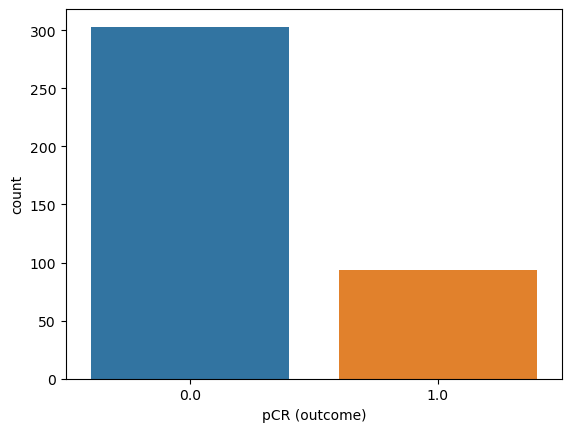

<Figure size 640x480 with 0 Axes>

In [6]:
# Countplot for classification
sns.countplot(x="pCR (outcome)", data=multi_imputed_df)
plt.figure()

#### 5. Split the data into features and target values

In [7]:
# Contains the data of 117 features
X = multi_imputed_df.iloc[:, 2:]

# Contains the target values: pCR (outcome)
classification_target = multi_imputed_df.iloc[:, :1]

#### 6. Split the clinical feature and image feature for feature selection

In [8]:
# Stores the clinical features
X_clinical = X.iloc[:,:10]

# Stores the image features
X_image = X.iloc[:,10:]

---
## <ins>Feature Selection Method</ins>

#### 1. Clinical feature selection using chi2 method

In [9]:
# Select the top 10 best clinical features
clinical_features = SelectKBest(chi2, k=10).fit(X_clinical, classification_target)

# Convert the selected clinical feature's header name into a list
clinical_features_list = list(clinical_features.get_feature_names_out())
print(clinical_features_list)

['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage']


In [10]:
Xn_clinical = X_clinical[clinical_features_list]

#### 2. Feature selection method on image-based features

- Random forest hyperparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

rf_pre = RandomForestClassifier()

# The parameter range for hyperparameter tuning
param_grid = { 
    'random_state': [42],
    'class_weight': ['balanced'],
    'n_estimators': np.arange(100,400,100).tolist(),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'criterion' :['gini', 'entropy']
}      
                           
CV_rfc = GridSearchCV(estimator=rf_pre, param_grid=param_grid, cv= 5, verbose=3)
CV_rfc.fit(X_image, classification_target)

print(CV_rfc.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, random_state=42;, score=0.713 total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, random_state=42;, score=0.675 total time=   0.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, random_state=42;, score=0.620 total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, random_state=42;, score=0.696 total time=   0.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, random_state=42;, score=0.608 total time=   0.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=200, random_state=42;, score=0.725 total time=   0.1s
[CV 2/5] END class_weight=balanc

#### 2. Initialise the RandomForestClassifier using the tunned hyperparameter

In [12]:
# Best parameter: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 300, 'random_state': 42}
rf = RandomForestClassifier(**CV_rfc.best_params_)
rf.fit(X_image, classification_target)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=300,
                       random_state=42)

#### 3. Construct the N-Best image-based feature from RF feature selection

Text(0.5, 0, 'Random Forest Feature Importance')

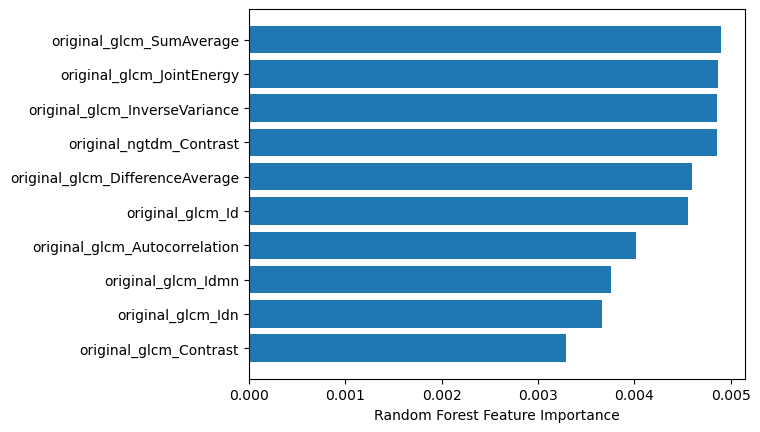

In [13]:
# Sort the features
sorted_idx = rf.feature_importances_.argsort()
# Choose th top K-number of features
num_select_features = 10
sorted_idx = sorted_idx[:num_select_features]

# Display the plot
plt.barh(X_image.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [14]:
# Assigned the selected feature
Xn_image = X_image.iloc[:, sorted_idx]
print(Xn_image.columns)

Index(['original_glcm_Contrast', 'original_glcm_Idn', 'original_glcm_Idmn',
       'original_glcm_Autocorrelation', 'original_glcm_Id',
       'original_glcm_DifferenceAverage', 'original_ngtdm_Contrast',
       'original_glcm_InverseVariance', 'original_glcm_JointEnergy',
       'original_glcm_SumAverage'],
      dtype='object')


#### 4. Concatenate the clinical and image-based features into a Dataframe

In [15]:
Xn = pd.concat([Xn_clinical, Xn_image], axis=1, join='inner')
print(Xn.columns)

Index(['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage',
       'original_glcm_Contrast', 'original_glcm_Idn', 'original_glcm_Idmn',
       'original_glcm_Autocorrelation', 'original_glcm_Id',
       'original_glcm_DifferenceAverage', 'original_ngtdm_Contrast',
       'original_glcm_InverseVariance', 'original_glcm_JointEnergy',
       'original_glcm_SumAverage'],
      dtype='object')


#### 5. Divide the concatenated data into training and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(Xn, 
                                                    classification_target,
                                                    stratify=classification_target,
                                                    test_size=0.3, 
                                                    random_state=42)


#### 6. Data Normalisation using StandardScaler()

In [17]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

___
## <ins>Predictive model building</ins>

#### 1. Predictive models hyperparameter tuning

In [18]:
# Random Forest Classification model initialisation
rf_clf = RandomForestClassifier(random_state=42)

# Random Forest Classification model's parameter grid
f_rf_search = GridSearchCV(rf_clf,
                            param_grid={'random_state': [42],
                                        'n_estimators': np.arange(90,200,15).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'max_depth' : [3,5,7,9],
                                        'criterion' :['gini'],
                                        'class_weight': ['balanced']},
                            scoring='accuracy',
                           verbose=3)

# --------------------------------------------------------------------------
# Support Vector Classifier model initialisation
rf_svc = SVC(random_state=42)

# Support Vector Classifier model's parameter grid
f_svc_search = GridSearchCV(rf_svc,
                            param_grid={'random_state': [42],
                                        'probability': [True],
                                        'C': [0.1,1, 10, 100], 
                                        'gamma': [1,0.1,0.01,0.001],
                                        'kernel': ['rbf', 'poly', 'sigmoid'],
                                        'class_weight': ['balanced']},
                            scoring='accuracy',
                           verbose=3)

# --------------------------------------------------------------------------
# Logistic Regression model initialisation
rf_lr = LogisticRegression(random_state=42)

# Logistic Regression model's parameter grid
f_lr_search = GridSearchCV(rf_lr,
                            param_grid={'random_state': [42],
                                        'C': [0.1,1, 10, 100], 
                                        'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                                        'class_weight': ['balanced']},
                            scoring='accuracy',
                           verbose=3)

In [19]:
# Run fit with all sets of parameters
# Random Forest Classifier
f_rf_search.fit(Xs_train, y_train)

# SVC
f_svc_search.fit(Xs_train, y_train)

# Logistic Regression
f_lr_search.fit(Xs_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.589 total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.625 total time=   0.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.764 total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.727 total time=   0.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.691 total time=   0.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=105, random_state=42;, score=0.607 total time=   0.0s
[CV 2/5] END class_weight=balanced, c

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=3)

#### 2. Best parameters and Accuracy of the Predictive models

In [20]:
print("Best parameter for Random Forest Classification ", f_rf_search.best_params_)
print("Accuracy: ", f_rf_search.best_score_, "\n")

print("Best parameter for SVC ", f_svc_search.best_params_)
print("Accuracy: ", f_svc_search.best_score_, "\n")

print("Best parameter for Logistic Regression ", f_lr_search.best_params_)
print("Accuracy: ", f_lr_search.best_score_, "\n")

Best parameter for Random Forest Classification  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 165, 'random_state': 42}
Accuracy:  0.7405194805194806 

Best parameter for SVC  {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Accuracy:  0.761948051948052 

Best parameter for Logistic Regression  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Accuracy:  0.7010389610389611 



---
## <ins>Evaluation Results</ins>

#### 1. Plot confusion Matrix (Random Forest Classifier, SVC, Logistic Regression)

In [21]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (5.0, 5.0)})
plt.rcParams.update({'font.size': 10})

Random Forest Classification Training accuracy: 0.924187725631769
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81        92
         1.0       0.38      0.39      0.39        28

    accuracy                           0.71       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.71      0.71      0.71       120



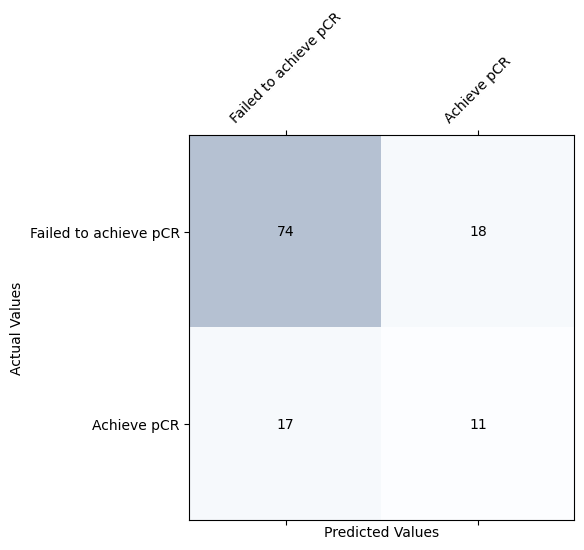

In [22]:
# Fit Random Forest Classification with the best parameter 
rf= RandomForestClassifier(**f_rf_search.best_params_)

rf.fit(X_train, y_train)
print(f"Random Forest Classification Training accuracy: {accuracy_score(y_train, rf.predict(X_train))}")
y_pred =rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Failed to achieve pCR","Achieve pCR"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

SVC Training accuracy: 0.9891696750902527
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86        92
         1.0       0.25      0.04      0.06        28

    accuracy                           0.75       120
   macro avg       0.51      0.50      0.46       120
weighted avg       0.65      0.75      0.67       120



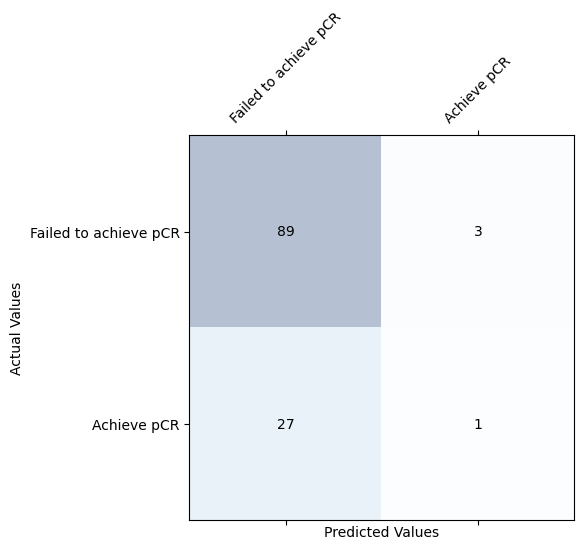

In [23]:
# Fit SVC with the best parameter 
svc = SVC(**f_svc_search.best_params_)

svc.fit(X_train, y_train)
print(f"SVC Training accuracy: {accuracy_score(y_train, svc.predict(X_train))}")
y_pred =svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Failed to achieve pCR","Achieve pCR"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

Logistic Regression Training accuracy: 0.7075812274368231
              precision    recall  f1-score   support

         0.0       0.77      0.60      0.67        92
         1.0       0.24      0.43      0.31        28

    accuracy                           0.56       120
   macro avg       0.51      0.51      0.49       120
weighted avg       0.65      0.56      0.59       120



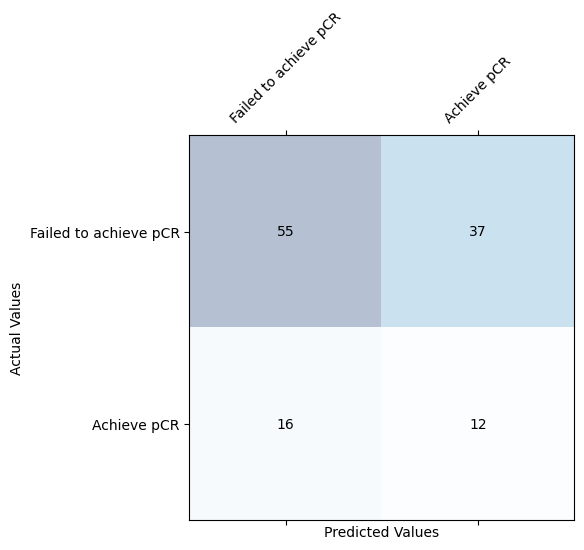

In [24]:
# Fit Logistic Regression with the best parameter 
lr = LogisticRegression(**f_lr_search.best_params_)

lr.fit(X_train, y_train)
print(f"Logistic Regression Training accuracy: {accuracy_score(y_train, lr.predict(X_train))}")
y_pred =lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Failed to achieve pCR","Achieve pCR"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

#### 2. 5-Fold Cross validation (Random Forest, SVC, Logistic Regression)

In [25]:
models = []
models.append(("Random Forest", rf))
models.append(("SVC", svc))
models.append(("lr", lr))

# Test options and evaluation metric
num_folds = 5
num_instances = len(X_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest  : 0.703961 (0.024430)
SVC            : 0.725260 (0.065976)
lr             : 0.686623 (0.089782)


#### 3. Plot ROC (Random Forest, SVC, Logistic Regression)

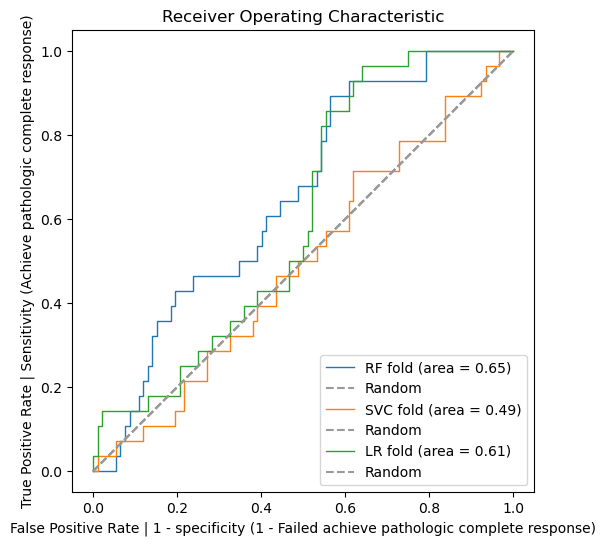

In [26]:
plt.figure(figsize=(8,6))

probas_ = [rf.predict_proba(X_test), svc.predict_proba(X_test), lr.predict_proba(X_test)]

# Store the respective classification models and probabilities of possible outcomes of testing set
probas_dict = {
    'RF': rf.predict_proba(X_test),
    'SVC': svc.predict_proba(X_test),
    'LR': lr.predict_proba(X_test),
}

# Plot the ROC curve of RF, SVC & LR
for model, probas_ in probas_dict.items():
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'{model} fold (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate | 1 - specificity (1 - Failed achieve pathologic complete response)')
    plt.ylabel('True Positive Rate | Sensitivity (Achieve pathologic complete response)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.axes().set_aspect(1)

---
## <ins>Final Model building using the entire dataset</ins>

In [27]:
# Initialise Random forest classifier with the best parameter
rf_model = RandomForestClassifier(**f_rf_search.best_params_)

# Normalise data
Xns = scaler.fit_transform(Xn)

# Train Random forest classifier with the entire dataset
rf_model.fit(Xns, classification_target)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=165,
                       random_state=42)

#### Save the Random Forest Classifier model using pickle

In [28]:
# Dump the model
with open("RandomForestClassifier.pickle", "wb") as f:
    pickle.dump(rf_model, f)

# Read the model
# with open("filename.pickle", "rb") as f:
#     someobject = pickle.load(f)